In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('icefire')

Load data

In [2]:
df = pd.read_csv('../inputs/data/train.csv')
df.shape

(3461, 36)

Observe features

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3461 entries, 0 to 3460
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sample_id                 3461 non-null   int64  
 1   station                   3461 non-null   int64  
 2   month                     3461 non-null   int64  
 3   fapar                     3461 non-null   float64
 4   modis_blue                3461 non-null   float64
 5   modis_red                 3461 non-null   float64
 6   modis_nir                 3461 non-null   float64
 7   modis_mir                 3461 non-null   float64
 8   modis_evi                 3461 non-null   float64
 9   modis_ndvi                3461 non-null   float64
 10  modis_lst_day_p05         3461 non-null   float64
 11  modis_lst_day_p50         3461 non-null   float64
 12  modis_lst_day_p95         3461 non-null   float64
 13  modis_lst_night_p05       3461 non-null   float64
 14  modis_ls

Target (Monthly mean FAPAR)

FAPAR represents the fraction of the incoming (photosynthetic active) radiation that is absorbed by vegetation, and is given in the range 0-1. It is a measure of vegetation health and ecosystem functioning, and a key parameter in light use efficiency models that model primary productivity.

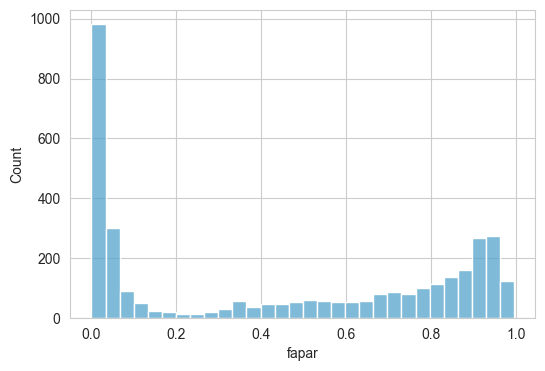

In [4]:
plt.figure(figsize = (6, 4))
sns.histplot(data = df, x = 'fapar', bins = 30)
plt.show()

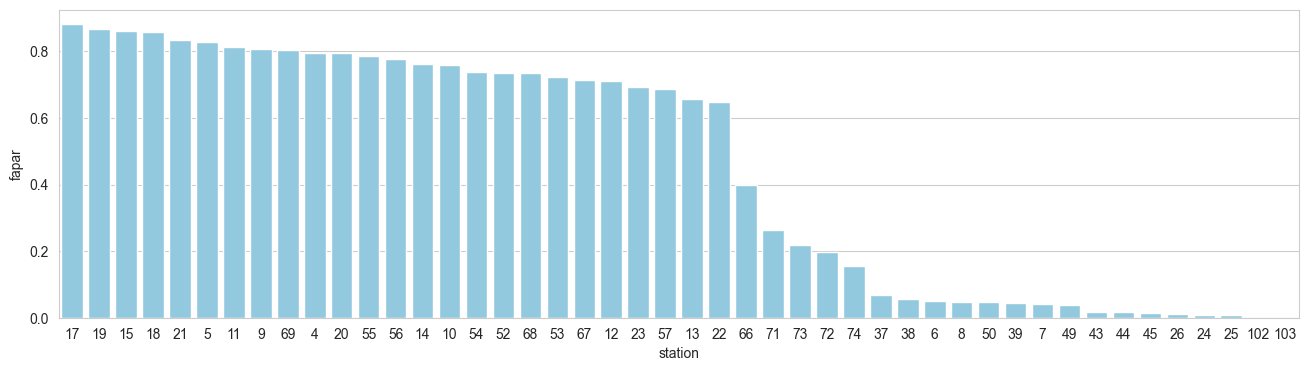

In [5]:
plt.subplots(1, 1, figsize = (16, 4))
fapar_by_station = df.groupby(by = 'station')['fapar'].mean().reset_index().sort_values(by = 'fapar', ascending = False)
sns.barplot(data = fapar_by_station, 
            x = 'station',
            y = 'fapar', 
            order = fapar_by_station['station'],
            color = 'skyblue')
plt.show()

In [6]:
# Groups
lg = fapar_by_station[fapar_by_station['fapar'] < 0.1]['station'].values.tolist()
mg = [s for s in fapar_by_station[fapar_by_station['fapar'] < 0.5]['station'].values.tolist() if s not in lg]
hg = [s for s in fapar_by_station['station'] if s not in lg + mg]
print(f'Low fapar groups        (< 0.1        ): [{len(lg):2d}] {sorted(lg)}')
print(f'Mid value fapar groups  (> 0.1 & < 0.5): [{len(mg):2d}] {sorted(mg)}')
print(f'High fapar groups       (> 0.5        ): [{len(hg):2d}] {sorted(hg)}')

Low fapar groups        (< 0.1        ): [16] [6, 7, 8, 24, 25, 26, 37, 38, 39, 43, 44, 45, 49, 50, 102, 103]
Mid value fapar groups  (> 0.1 & < 0.5): [ 5] [66, 71, 72, 73, 74]
High fapar groups       (> 0.5        ): [25] [4, 5, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 52, 53, 54, 55, 56, 57, 67, 68, 69]


- More than 1/3rd of records are with fapar less than 0.1
- Monthly mean fapar measured by the stations 102 and 103 are 0.
- Station 6, 7, 8, 24, 25, 26, 37, 38, 39, 43, 44, 45, 49, and 50 are with low mean fapar 

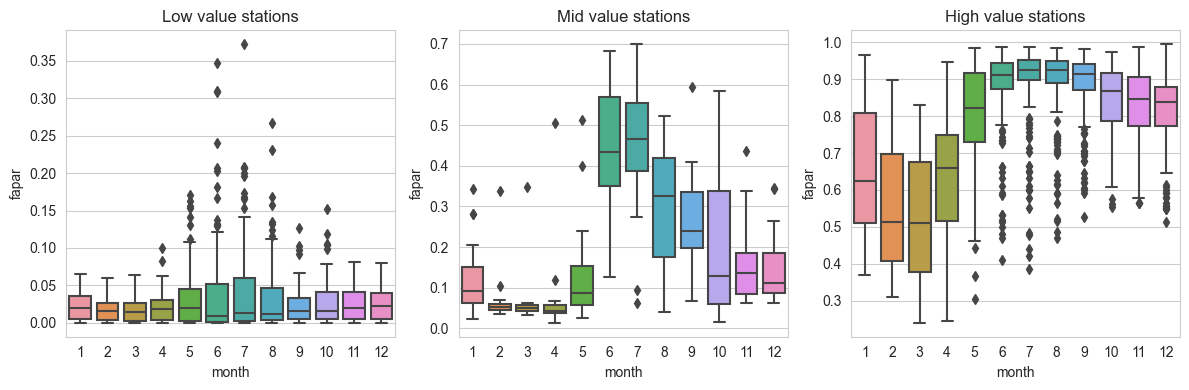

In [7]:
fig, axes = plt.subplots(1, 3, figsize = (12, 4))
for idx, (group, name) in enumerate(zip([lg, mg, hg], ['Low value stations', 'Mid value stations', 'High value stations'])):
    sns.boxplot(data = df[df['station'].isin(group)], y = 'fapar', x = 'month', ax = axes[idx])
    axes[idx].set_title(name)
plt.tight_layout()
plt.show()

- Between April and September, the variance in monthly mean fapar across the three groups is higher. 
- Low fapar stations have much tighter distribution in the rest of the months.

Correlation between numerical features

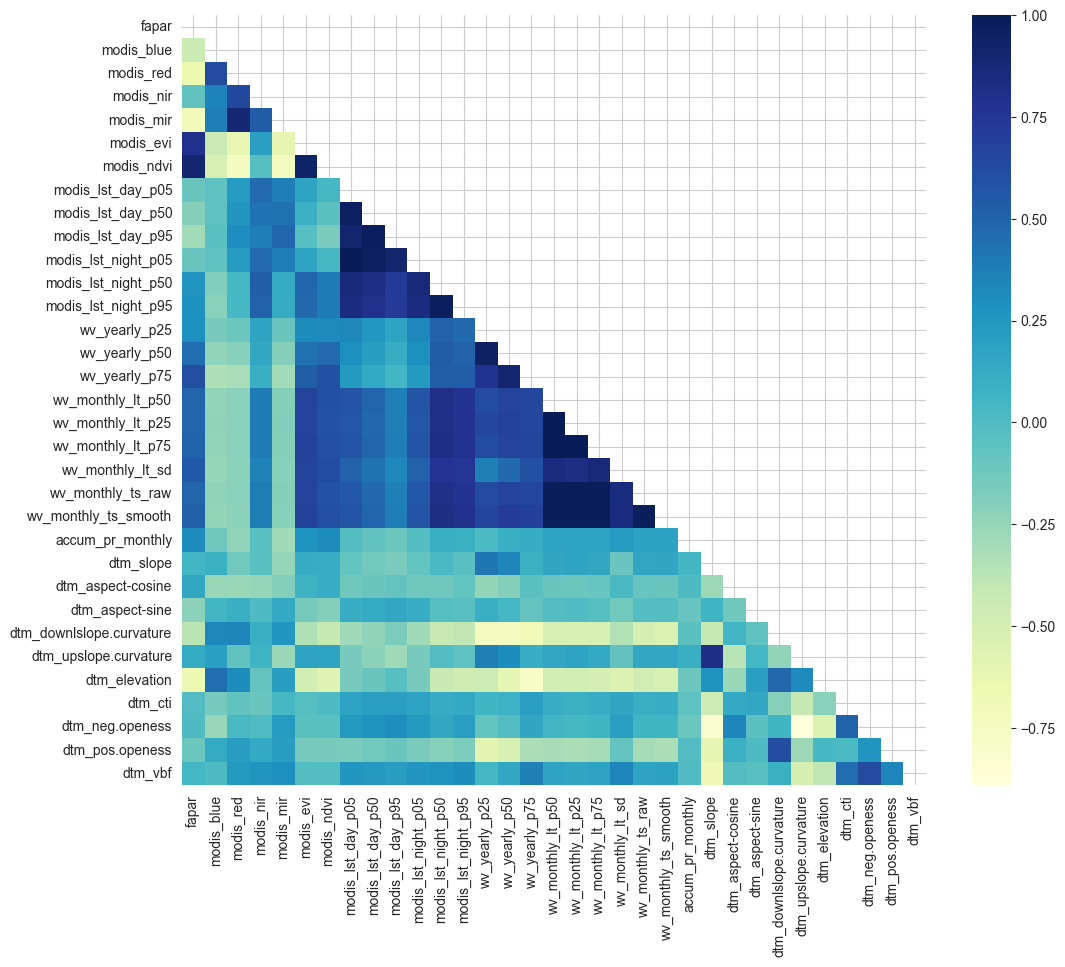

In [17]:
cat_features = ['sample_id', 'station', 'month']
num_features = [c for c in df.columns if c not in cat_features]

plt.figure(figsize = (12, 10))
corr = df[num_features].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(data = corr, mask = mask, cmap = 'YlGnBu', annot = False)
plt.show()

- fapar seems to have strong correlation with various indicies including modi_{nir, red, mr, evi, ndvi}
- modis_last_day percentile values are also strongly correlated. 
- Must do feature selection to remove features some of these correlated features
- Also should consider for driven features

Features distrubtion

In [20]:
# append station groups
def assign_group(x):
    if x in lg:
        return 'lg'
    elif x in mg:
        return 'mg'
    elif x in hg:
        return 'hg'
    else:
        return None
df['groups'] = df['station'].apply(lambda x: assign_group(x))

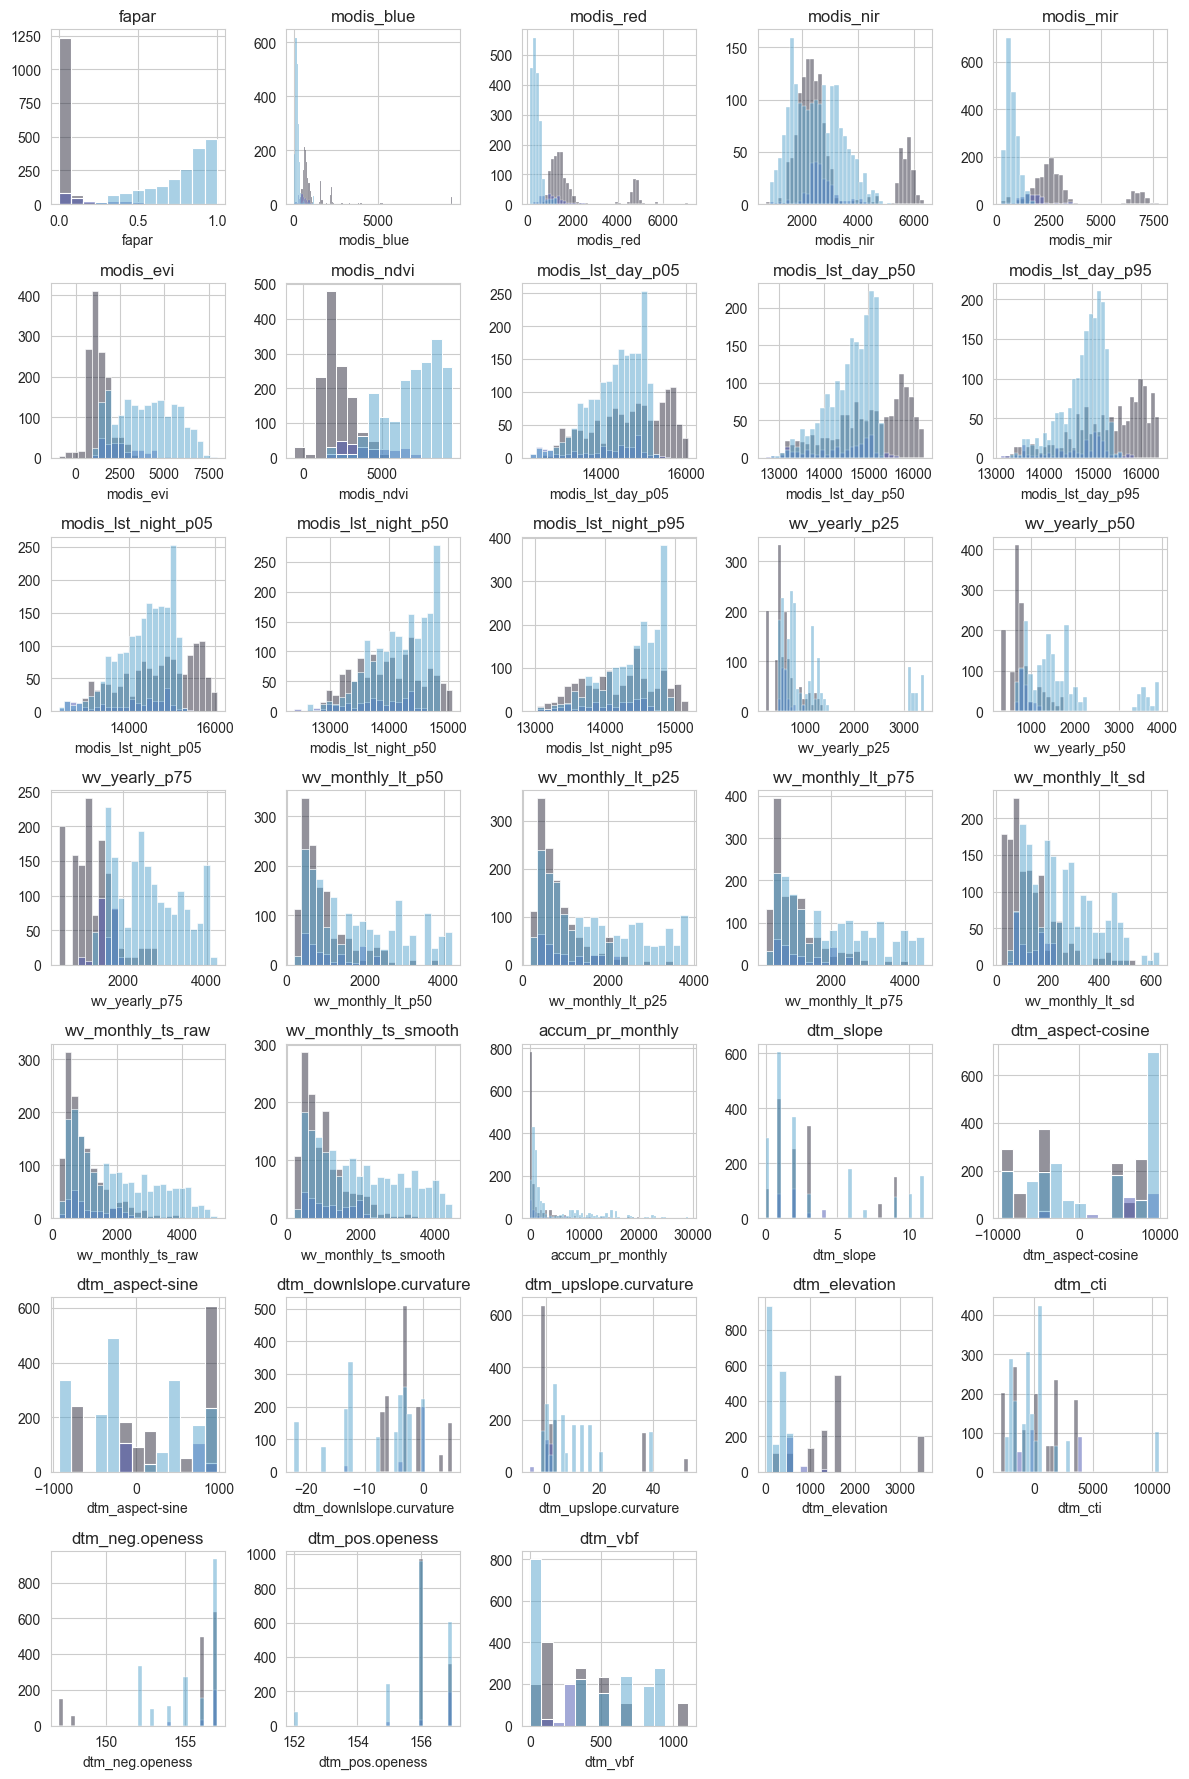

In [34]:
fig, axes = plt.subplots(8, 5, figsize = (12, 20))
for idx, ax in enumerate(axes.flatten()):
    if idx < len(num_features):
        sns.histplot(data = df, x = num_features[idx], hue = 'groups', ax = ax) 
        ax.set_title(num_features[idx])
        ax.set_ylabel(None)
        ax.get_legend().set_visible(False)
    else:
        ax.remove()
    
plt.tight_layout()
plt.show()

It seems dtm_neg.openess, dtm_pos.openess, and dtm_slope categorical

In [60]:
#df['target_bins'] = pd.qcut(df['fapar'], bins = 5)
df['target_bins'] = pd.qcut(df['fapar'], q = 4, labels = False)

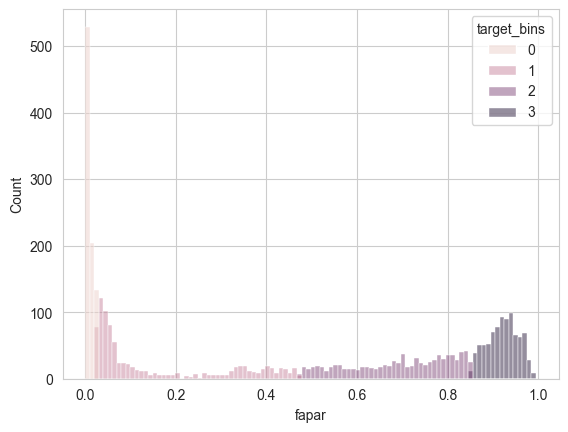

In [61]:
sns.histplot(data = df, x = 'fapar', hue = 'target_bins', bins = 100)
plt.show()

In [53]:
df['target_bins'].unique()

[(0.199, 0.398], (0.597, 0.796], (0.796, 0.995], (0.398, 0.597], (-0.000995, 0.199]]
Categories (5, interval[float64, right]): [(-0.000995, 0.199] < (0.199, 0.398] < (0.398, 0.597] < (0.597, 0.796] < (0.796, 0.995]]